## Bayesian Analysis of KINN Cas9 when Varying State numbers

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pickle

import arviz as az
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# utils functions

def parse_arc_str(arc):
    rates = {}
    for i, a in enumerate(arc.split('|')):
        ele = a.split('-')
        #rates.append([int(ele[0]), int(ele[1]), int(ele[2].strip('k'))])
        rates[('k%i'%i, 'start')] = int(ele[0])
        rates[('k%i'%i, 'length')] = int(ele[1]) - int(ele[0])
        rates[('k%i'%i, 'kernel')] = int(ele[2].strip('k'))
    return rates

def get_post_dist(df, top_cut=0.05):
    if type(top_cut) is float:
         top_cut = int(df.shape[0]*top_cut)
    a = df.sort_values('test_reward', ascending=False).head(top_cut)
    n_rates = len(df.iloc[0]['arc'].split('|'))
    rates = pd.DataFrame(columns=[
        ['k%i'%i for i in range(n_rates) for _ in range(3)], 
        ['start', 'length', 'kernel']*n_rates] )
    for arc in a['arc']:
        r = parse_arc_str(arc)
        rates = rates.append(r, ignore_index=True)
    return rates

def fit_mvn(post):
    a = post[["k%i"%k for k in range(2, len(post.columns.levels[0]))]].to_numpy(dtype='float32')
    #a = post.to_numpy(dtype='float32')
    mu = np.mean(a, axis=0)
    sigma = np.cov(a, rowvar=0)
    return mu, sigma

def bayes_heir_samp(ks):
    posts = [get_post_dist(k, top_cut=100) for k in ks]
    xs = [
        x[["k%i"%k for k in range(2, len(x.columns.levels[0]))]].to_numpy(dtype='float32')
        for x in posts
    ]
    with pm.Model() as heir_model:
        μ = pm.Normal("μ", 0.0, 5, shape=xs[0].shape[1], testval=np.concatenate(xs, axis=0).mean(axis=0))
        chol, corr, stds = pm.LKJCholeskyCov(
                "chol", n=xs[0].shape[1], eta=1.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
            )
        group_cov = pm.Deterministic("mvn_cov", chol.dot(chol.T))
        group_mvn = pm.MvNormal("mvn_mu", μ, chol=chol, shape=(xs[0].shape[1],))

        chol_i, _, _ = pm.LKJCholeskyCov(
            "chol_i", n=xs[0].shape[1], eta=1.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
        )
        cov = pm.Deterministic("cov_i", chol_i.dot(chol_i.T))
        for i, x in enumerate(xs):
            cov = pm.Deterministic("cov_%i"%i, chol.dot(chol.T))
            obs_i = pm.MvNormal("obs_%i"%i, group_mvn, chol=chol_i, observed=x)
        
        trace = pm.sample(draws=2000, tune=750, random_seed=1337, init="adapt_diag", target_accept=0.9, return_inferencedata=True)
    return trace

def strip_mat_coord(s):
    c = s.split('[')[1].strip(']').split(',')
    c = [int(x) for x in c if len(x)]
    return c

def make_sigma_from_coo(sigma_coo):
    last_dim = strip_mat_coord(sigma_coo.index[-1])
    sigma_ = np.zeros((last_dim[0]+1, last_dim[1]+1))
    for i, row in sigma_coo.iterrows():
        coords = strip_mat_coord(i)
        #print(coords, row['mean'])
        sigma_[coords[0], coords[1]] = row['mean']
        sigma_[coords[1], coords[0]] = row['mean']
    return sigma_

def bayes_trace_sum(trace):
    mu = az.summary(trace, var_names=["μ"], round_to=2)
    mvn_sigma = az.summary(trace, var_names=["mvn_cov"], round_to=2)
    inter_sigma = az.summary(trace, var_names=["cov_i"], round_to=2)
    mu = mu['mean'].to_numpy()
    return mu, make_sigma_from_coo(mvn_sigma), make_sigma_from_coo(inter_sigma)

In [4]:
# Plot functions
def plot_sigma(sigma, ax=None):
    ax = sns.heatmap(sigma, annot=True, ax=ax, center=0, cbar=False, fmt=".1f", 
                cmap=sns.color_palette("vlag", as_cmap=True),
                xticklabels=[f"k{k}_{s}" for k in range(2,2+sigma.shape[0]//3) for s in ('s', 'l', 'k')],
                #yticklabels=[f"k{k}_{s}" for k in range(2,7) for s in ('s', 'l', 'k')],
    )
    return ax


def plot_mean(mu, ax=None, verbose=False):
    offset = 0.25
    ax.text(1, 6+offset, "k0", fontsize=12)
    ax.plot((0,3), (6,6), lw=2, color="black")
    ax.text(1, 3+offset, "k1", fontsize=12)
    ax.plot((0,3), (3,3), lw=2, ls='--', color="red")

    k = 1
    for i in range(0, len(mu), 3):
        k += 1
        start = mu[i]
        end = mu[i] + mu[i+1]
        ks = mu[i+2]
        if verbose: print(start, end, ks)
        #ax.text(start+1, -i+offset, "k%i (%.2f)"%(k, ks), fontsize=12)
        ax.text(start+1, -i+offset, "k%i"%(k), fontsize=12)
        if k%2:
            ax.plot((start, end), (-i,-i), lw=2, color="red", ls="--")
        else:
            ax.plot((start, end), (-i,-i), lw=2, color="black")

    ax.set_xlim(0, 25)
    ax.set_xlabel("gRNA")
    ax.set_yticklabels("")
   

In [5]:
train_hist_dict = {
'finkelstein-gRNA1': [
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep1-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep2-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA1/train_history.tsv"),
    ],
'finkelstein-gRNA2': [
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep1-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep2-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/train_history.tsv"),
    ],
'uniform-4-gRNA1': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep1-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep2-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep3-gRNA1/train_history.tsv"),
    ],
'uniform-4-gRNA2': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep1-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep2-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-4-rep3-gRNA2/train_history.tsv"),
    ],
'uniform-5-gRNA1': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep1-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep2-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep3-gRNA1/train_history.tsv"),
    ],
'uniform-5-gRNA2': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep1-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep2-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-5-rep3-gRNA2/train_history.tsv"),
    ],
'uniform-6-gRNA1': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep1-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep2-gRNA1/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep3-gRNA1/train_history.tsv"),
    ],
'uniform-6-gRNA2': [
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep1-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep2-gRNA2/train_history.tsv"),
    pd.read_table("outputs/2022-05-30/KINN-wtCas9_cleave_rate_log-uniform-6-rep3-gRNA2/train_history.tsv"),
    ],        
}

In [6]:
res = {}
for k in train_hist_dict:
    print(k)
    post_all = get_post_dist(pd.concat(train_hist_dict[k]), top_cut=200)
    mu, sigma = fit_mvn(post_all)
    res[k] = mu, sigma

finkelstein-gRNA1
finkelstein-gRNA2
uniform-4-gRNA1
uniform-4-gRNA2
uniform-5-gRNA1
uniform-5-gRNA2
uniform-6-gRNA1
uniform-6-gRNA2


<Figure size 432x288 with 0 Axes>

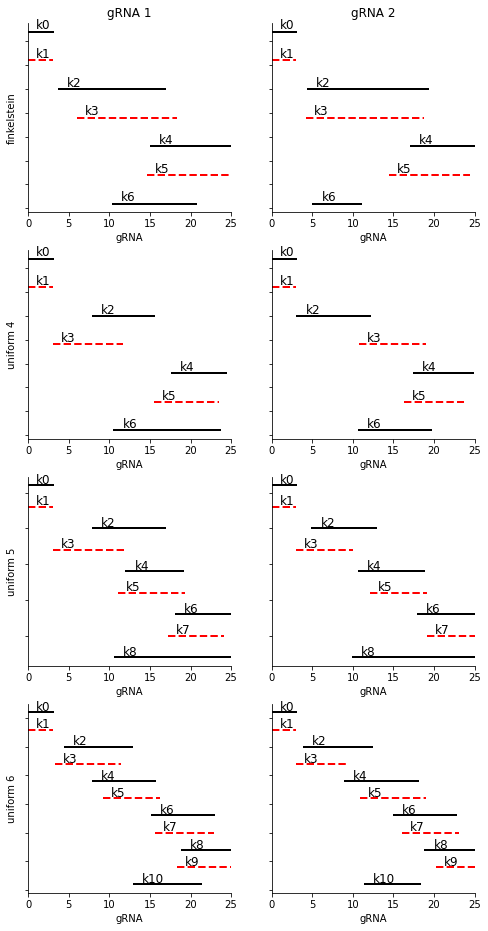

In [7]:
plt.clf()
fig, axs = plt.subplots(len(res)//2, 2, figsize=(8, 4*len(res)//2))
i = 0
j = 0
for config in res:
    mu = res[config][0]
    ax = axs[i,j]
    plot_mean(mu, ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i==0:
        ax.set_title('gRNA %i' % (j+1))
    if j==1:
        j=0; i+=1
    else:
        ax.set_ylabel(' '.join(config.split('-')[:-1]))
        j+=1

### Bayesian Heirarchical Model Inference

Helps to tease out within-group (within an AMBER search run) variances vs between-group (between AMBER run) variances.

For the $j$-th searched KINN model on the $i$-th run, we spcecify the following model:

$$y_{ij} = \mu + b_i + \epsilon_{ij}$$

In other words, $\mu_i=\mu + b_i$, and $b_i \sim MVN(0, \Sigma_b)$

and $y_{ij} \sim MVN(\mu_i, \Sigma_y)$

$\Sigma_y$ captures the within-group variance, while $\Sigma_b$ captures the between-group variance.

We can put further priors to make a complete Bayesian model:

$$\mu \sim MVN(\theta, \Sigma_b)$$
$$\theta \sim N(0,10)$$
$$\Sigma_b \sim LKJCholeskyCov(\eta=1, sd\sim Exp(1.))$$
$$\Sigma_y \sim LKJCholeskyCov(\eta=1, sd\sim Exp(1.))$$

Note: Smaller $Exp(\lambda)$ are more flat / regularize less towards 0, because $E(Exp(\lambda)) = \frac{1}{\lambda}$


Based on https://idiom.ucsd.edu/~rlevy/pmsl_textbook/chapters/pmsl_8.pdf

In [8]:
# results placeholder
bh_res = {}

finkelstein-gRNA1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 1505 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
There were 1766 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5708993977356287, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8008225694054771, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1399 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8337205239440679, but should be close to 0.9. Try to increase the number of

finkelstein-gRNA2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 1344 seconds.
There were 1218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8046662100043874, but should be close to 0.9. Try to increase the number of tuning steps.
There were 921 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1359 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7510348029008935, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1874 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3755054879632197, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samp

uniform-4-gRNA1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 917 seconds.
There were 1463 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7090322769649735, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1336 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7860508851633329, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1335 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8146994862326624, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1502 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.756898805535019, but should be clos

uniform-4-gRNA2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 1191 seconds.
There were 1242 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7913619912672686, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5805290984112188, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.1768646138679983, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1615 divergences after tuning. Increase `target_accept` or reparameter

uniform-5-gRNA1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 1471 seconds.
There were 1707 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7574436942530751, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8116635318548726, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1618 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7965904073381913, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase

uniform-5-gRNA2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 1432 seconds.
There were 1492 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8339289753503467, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1624 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5830599311804955, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8077372853945399, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase

uniform-6-gRNA1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 2463 seconds.
There were 985 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7963690410283546, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1335 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 649 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase tar

uniform-6-gRNA2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_i, mvn_mu, chol, μ]


Sampling 4 chains for 750 tune and 2_000 draw iterations (3_000 + 8_000 draws total) took 2019 seconds.
There were 1141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9911106173478323, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.5821546475026096, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.4621962747178743, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The accep

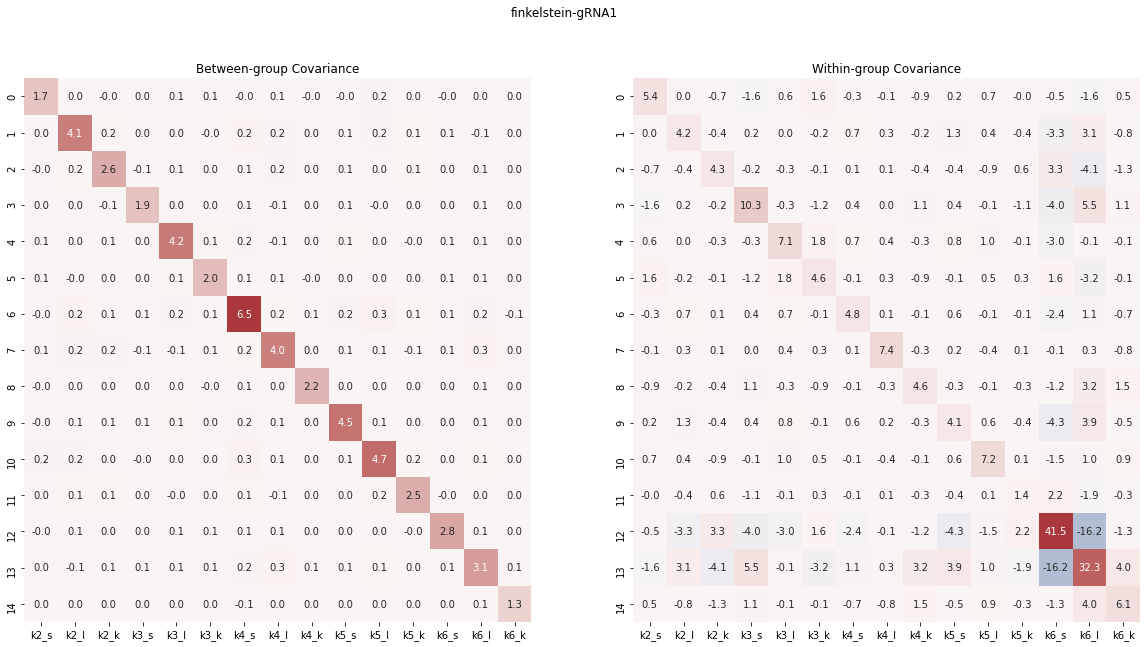

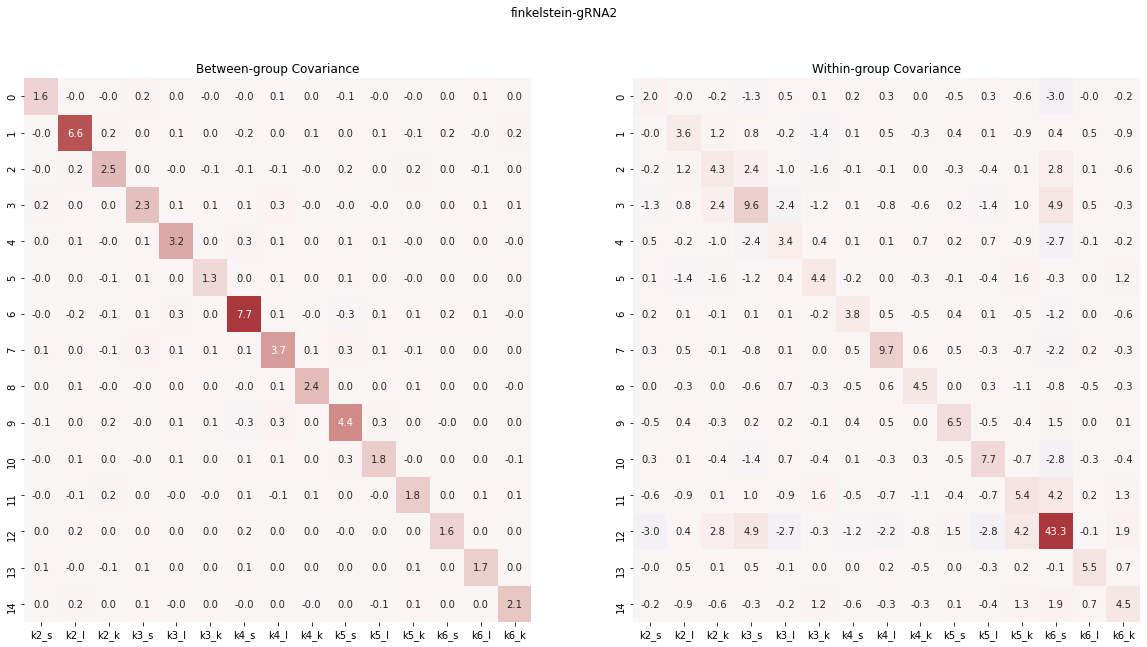

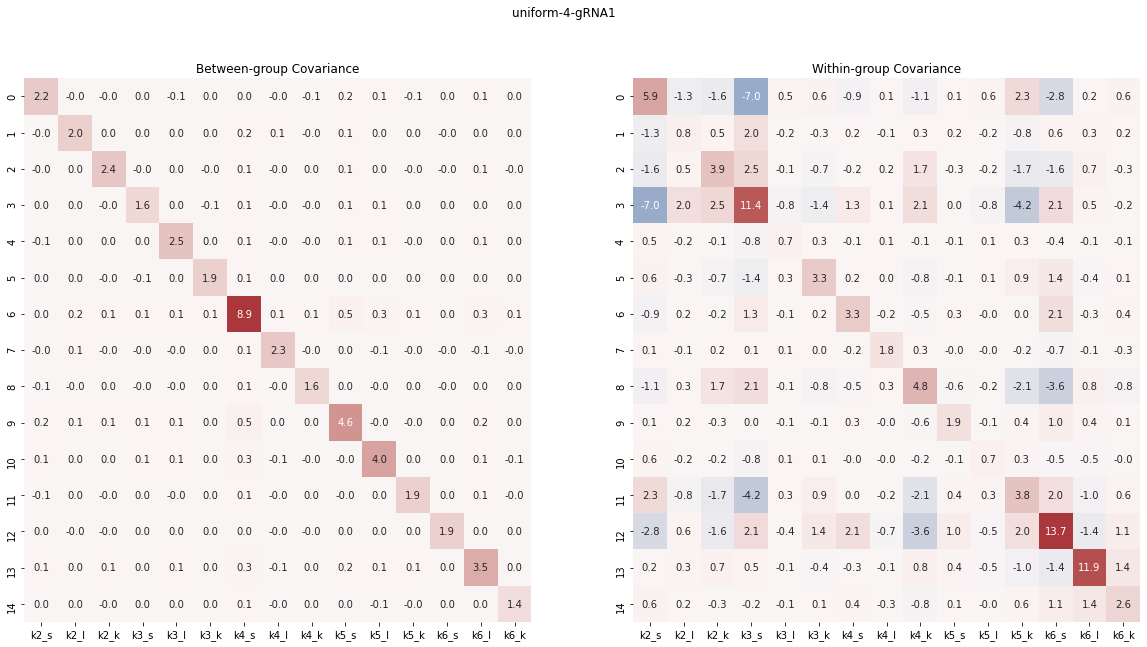

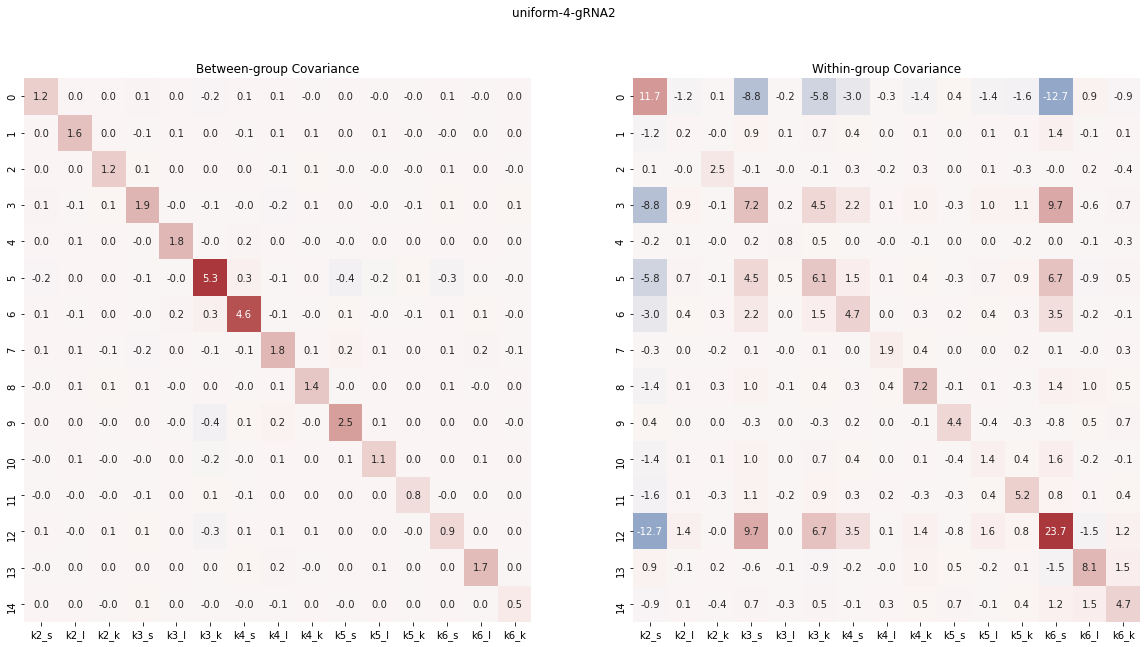

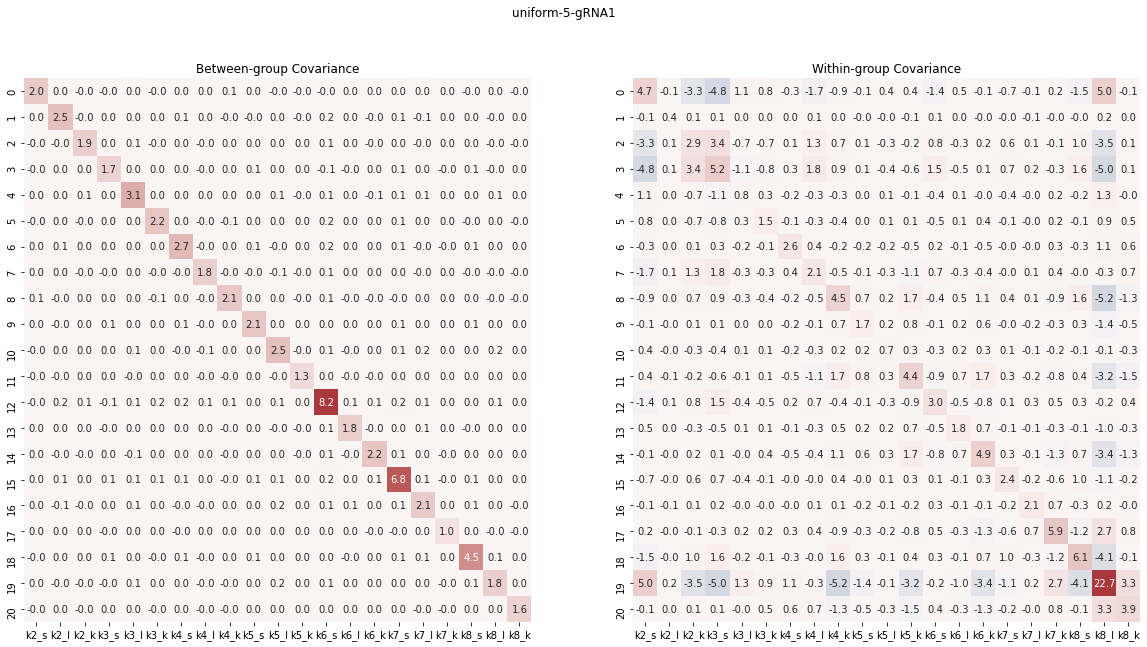

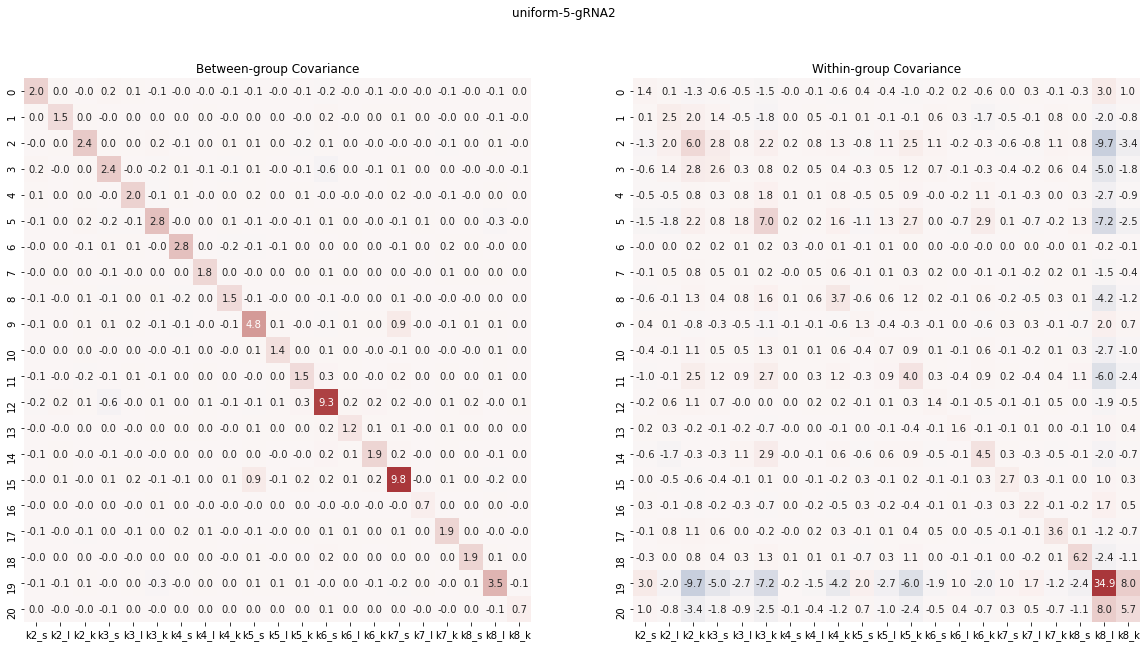

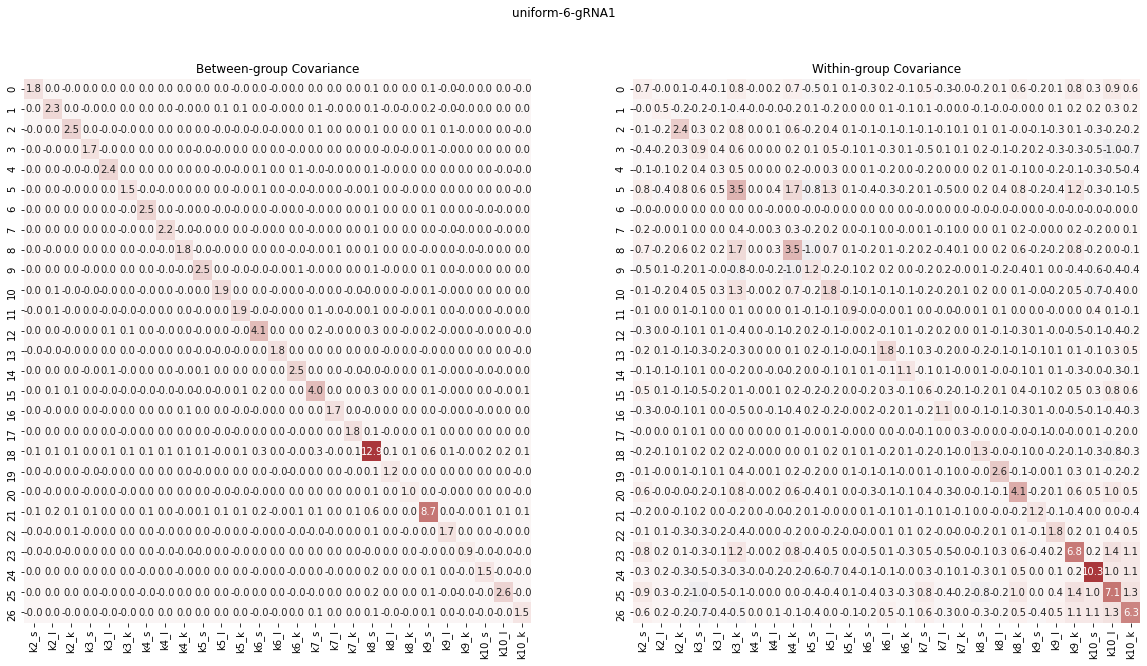

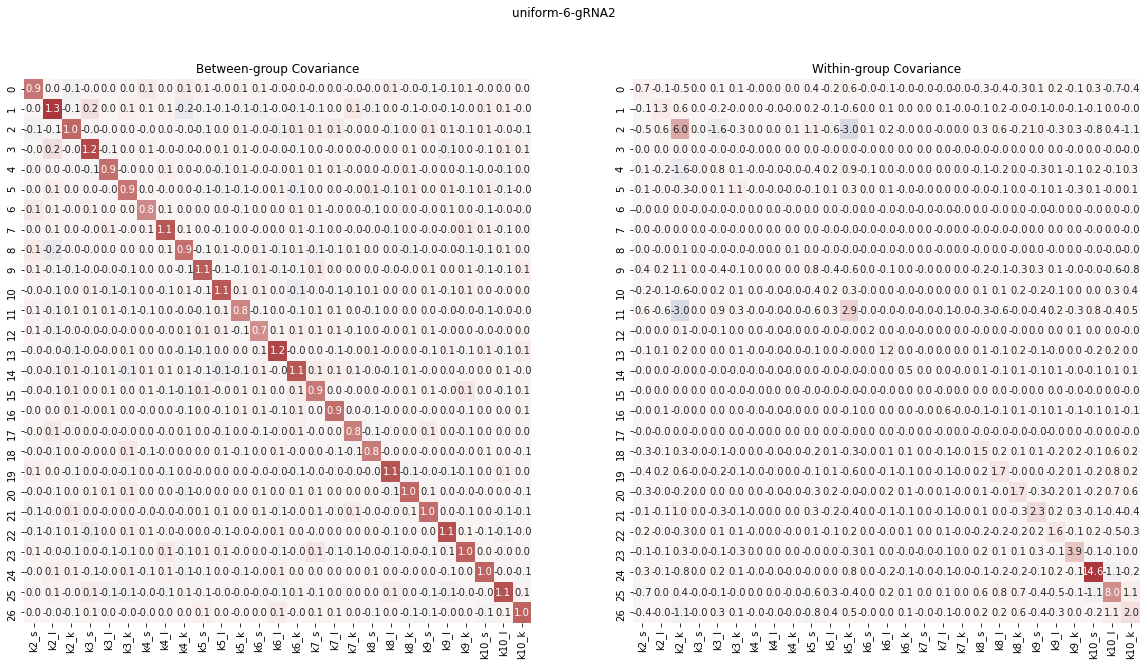

In [9]:
for config in train_hist_dict:
    if config in bh_res:
        continue
    print(config)
    ks = train_hist_dict[config]
    trace = bayes_heir_samp(ks)
    theta, sigma_b, sigma_y = bayes_trace_sum(trace)
    bh_res[config] = theta, sigma_b, sigma_y
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    plot_sigma(sigma_b, ax=ax[0])
    ax[0].set_title("Between-group Covariance")
    plot_sigma(sigma_y, ax=ax[1])
    ax[1].set_title("Within-group Covariance")
    fig.suptitle(config)
    fig.savefig(f"{config}-bayes-cov.pdf")

<Figure size 432x288 with 0 Axes>

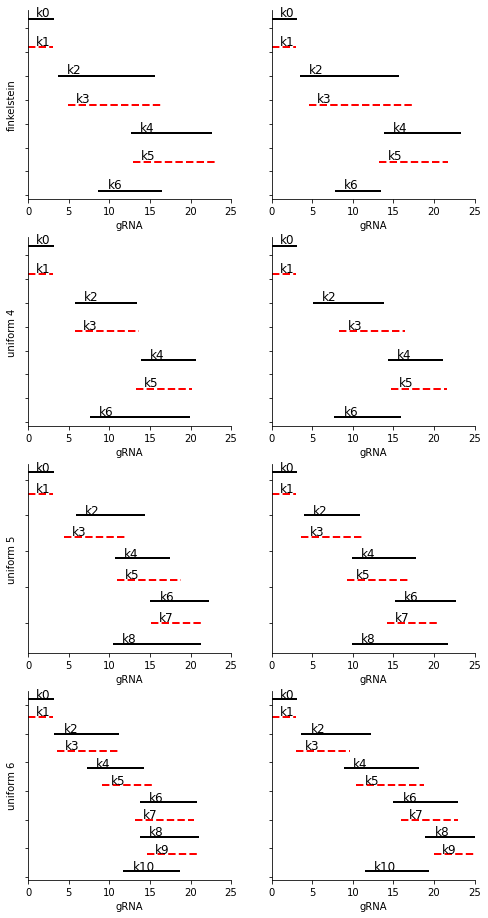

In [10]:
plt.clf()
fig, axs = plt.subplots(len(res)//2, 2, figsize=(8, 4*len(res)//2))
i = 0
j = 0
for config in res:
    mu = bh_res[config][0]
    ax = axs[i,j]
    plot_mean(mu, ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if j==1:
        j=0; i+=1
    else:
        ax.set_ylabel(' '.join(config.split('-')[:-1]))
        j+=1

In [11]:
pickle.dump(bh_res, open('bh_res.pkl', "wb"))

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

numpy     : 1.21.6
pymc3     : 3.11.5
scipy     : 1.7.3
seaborn   : 0.11.1
arviz     : 0.12.0
pandas    : 1.3.5
matplotlib: 3.4.3

Watermark: 2.3.1

